<a href="https://colab.research.google.com/github/jorge-flores-py/APRENDIZAJE-AUTOMATICO-2/blob/main/TP1_AA2_mnist_consigna_jorge_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico nro 1 de AA2.

**jorge flores**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.

In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[0, 8])



## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




### 2.1 Red que subajusta

In [ ]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super().__init__()
        # Capa lineal: de 784 (28x28 píxeles) → 2 (clases: 0 y 8)
        self.fc1 = nn.Linear(28*28, 2)

    def forward(self, x):
        # Aplanar imagen: de (batch, 1, 28, 28) → (batch, 784)
        x = x.view(-1, 28*28)
        # Pasar por la capa lineal
        x = self.fc1(x)
        return x


### 2.2 Red que sobre ajusta

In [ ]:
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super().__init__()
        # Varias capas con muchas neuronas
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)   # salida: 2 clases (0 y 8)

    def forward(self, x):
        # Aplanar imagen (batch, 1, 28, 28) → (batch, 784)
        x = x.view(-1, 28*28)
        # Pasar por varias capas densas con ReLU
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # Última capa (sin activación porque usamos CrossEntropyLoss)
        x = self.fc5(x)
        return x

### 2.3 MLP aceptable

In [ ]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super().__init__()
        # Capas ocultas moderadas
        self.fc1 = nn.Linear(28*28, 128)  # primera capa oculta
        self.fc2 = nn.Linear(128, 64)     # segunda capa oculta
        self.fc3 = nn.Linear(64, 2)       # capa de salida (2 clases)

    def forward(self, x):
        # Aplanar la imagen
        x = x.view(-1, 28*28)
        # Pasar por capa 1 + activación ReLU
        x = torch.relu(self.fc1(x))
        # Pasar por capa 2 + activación ReLU
        x = torch.relu(self.fc2(x))
        # Última capa: logits crudos (sin activación, porque usamos CrossEntropyLoss)
        x = self.fc3(x)
        return x

## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

### 3.1 Cargue los datos, divida los conjuntos de datos

In [ ]:
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

# 1. Definir transform (lo usamos en todos los datasets)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normaliza a [-1,1]
])

# 2. Cargar datasets filtrados (solo dígitos 0 y 8)
mnist_train = MNISTSubset(train=True, transform=transform, target_classes=[0, 8])
mnist_test  = MNISTSubset(train=False, transform=transform, target_classes=[0, 8])

# 3. Dividir train en train (80%) y validación (20%)
train_size = int(0.8 * len(mnist_train))
val_size   = len(mnist_train) - train_size
train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

# 4. DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
testloader  = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Verificación rápida
print("Tamaño train:", len(train_dataset))
print("Tamaño val:", len(val_dataset))
print("Tamaño test:", len(mnist_test))



Tamaño train: 9419
Tamaño val: 2355
Tamaño test: 1954


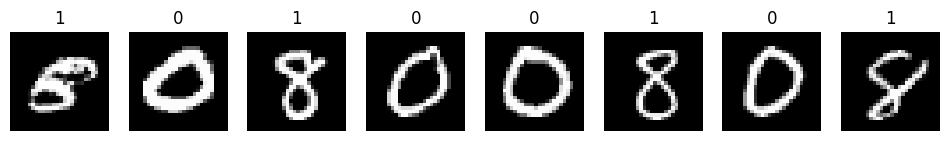

In [ ]:
import matplotlib.pyplot as plt

# Tomamos un batch de entrenamiento
images, labels = next(iter(trainloader))

# Mostramos las primeras 8 imágenes
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(str(labels[i].item()))
    axes[i].axis("off")

plt.show()


### 3.2 Entrene cada modelo.

In [ ]:
def entrenar_modelo(model, trainloader, valloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # ---- ENTRENAMIENTO ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # ---- VALIDACIÓN ----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        # guardar métricas
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return history


In [ ]:
def evaluar_modelo(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return test_loss / total, correct / total


In [ ]:
import matplotlib.pyplot as plt

def graficar_historial(history, titulo="Evolución del modelo"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # --- Gráfico de Loss ---
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Pérdida (Loss)")
    plt.legend()

    # --- Gráfico de Accuracy ---
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Precisión (Accuracy)")
    plt.legend()

    plt.suptitle(titulo, fontsize=14)
    plt.show()


### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



In [ ]:
modelo_sub = Modelo_NN_subajusta()

# Entrenar (train + val)
hist_sub = entrenar_modelo(modelo_sub, trainloader, valloader, epochs=5, lr=0.001)

# Evaluar en test
test_loss, test_acc = evaluar_modelo(modelo_sub, testloader)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


Epoch [1/5] Train Loss: 0.1219, Acc: 0.9610 | Val Loss: 0.0590, Acc: 0.9822
Epoch [2/5] Train Loss: 0.0455, Acc: 0.9866 | Val Loss: 0.0440, Acc: 0.9860
Epoch [3/5] Train Loss: 0.0340, Acc: 0.9901 | Val Loss: 0.0386, Acc: 0.9868
Epoch [4/5] Train Loss: 0.0297, Acc: 0.9918 | Val Loss: 0.0436, Acc: 0.9868
Epoch [5/5] Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0350, Acc: 0.9890
Test - Loss: 0.0270, Accuracy: 0.9923


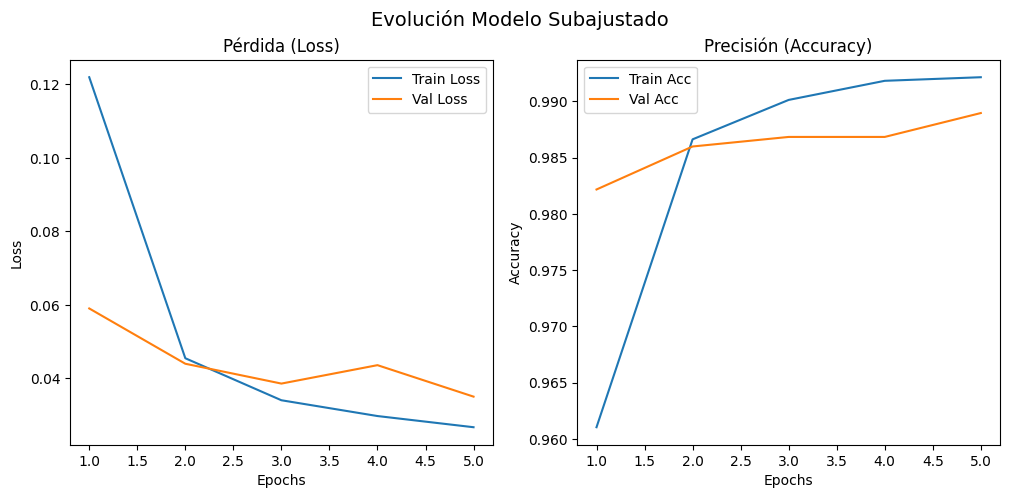

In [ ]:
graficar_historial(hist_sub, titulo="Evolución Modelo Subajustado")


In [ ]:
modelo_sub = Modelo_NN_SobreAjustado()

# Entrenar (train + val)
hist_sub = entrenar_modelo(modelo_sub, trainloader, valloader, epochs=5, lr=0.001)

# Evaluar en test
test_loss, test_acc = evaluar_modelo(modelo_sub, testloader)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Epoch [1/5] Train Loss: 0.0762, Acc: 0.9758 | Val Loss: 0.0338, Acc: 0.9873
Epoch [2/5] Train Loss: 0.0284, Acc: 0.9910 | Val Loss: 0.0254, Acc: 0.9919
Epoch [3/5] Train Loss: 0.0215, Acc: 0.9942 | Val Loss: 0.0283, Acc: 0.9898
Epoch [4/5] Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0291, Acc: 0.9915
Epoch [5/5] Train Loss: 0.0155, Acc: 0.9955 | Val Loss: 0.0131, Acc: 0.9936
Test - Loss: 0.0196, Accuracy: 0.9933


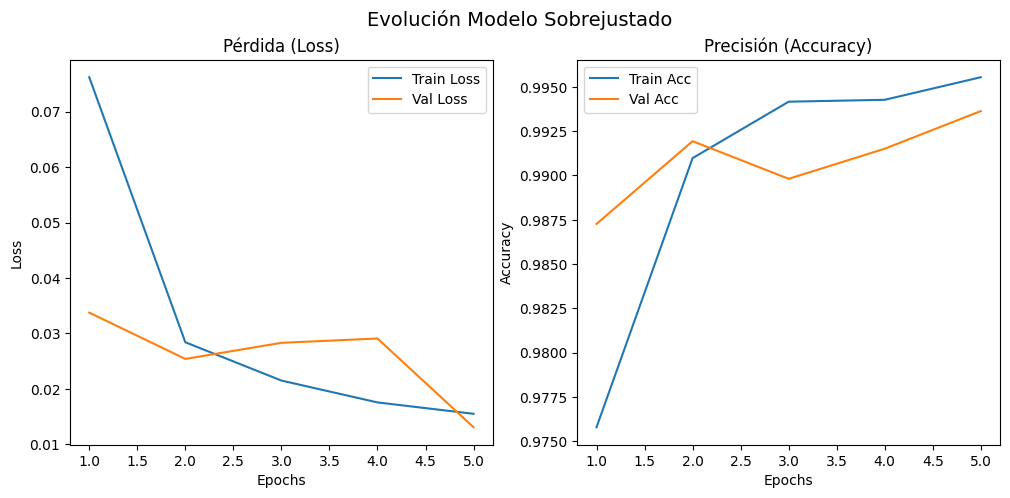

In [ ]:
graficar_historial(hist_sub, titulo="Evolución Modelo Sobrejustado")

In [ ]:
modelo_sub =  Modelo_NN_aceptable()

# Entrenar (train + val)
hist_sub = entrenar_modelo(modelo_sub, trainloader, valloader, epochs=5, lr=0.001)

# Evaluar en test
test_loss, test_acc = evaluar_modelo(modelo_sub, testloader)
print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

Epoch [1/5] Train Loss: 0.0742, Acc: 0.9766 | Val Loss: 0.0379, Acc: 0.9885
Epoch [2/5] Train Loss: 0.0243, Acc: 0.9929 | Val Loss: 0.0305, Acc: 0.9902
Epoch [3/5] Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0212, Acc: 0.9919
Epoch [4/5] Train Loss: 0.0145, Acc: 0.9961 | Val Loss: 0.0142, Acc: 0.9949
Epoch [5/5] Train Loss: 0.0093, Acc: 0.9978 | Val Loss: 0.0216, Acc: 0.9919
Test - Loss: 0.0227, Accuracy: 0.9918


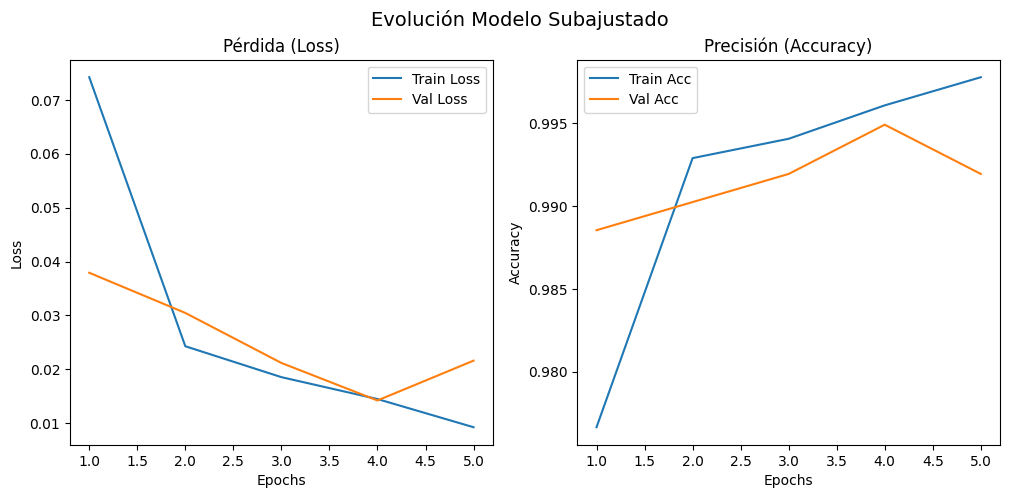

In [ ]:
graficar_historial(hist_sub, titulo="Evolución Modelo Aceptable")

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------
# 1. Modelo flexible
# ----------------------------
class ModeloFlexible(nn.Module):
    def __init__(self, neuronas_capa1=128, neuronas_capa2=64):
        super().__init__()
        self.fc1 = nn.Linear(28*28, neuronas_capa1)          # entrada 784 → capa oculta 1
        self.fc2 = nn.Linear(neuronas_capa1, neuronas_capa2) # capa oculta 1 → capa oculta 2
        self.fc3 = nn.Linear(neuronas_capa2, 2)              # capa oculta 2 → salida (2 clases: 0 u 8)

    def forward(self, x):
        x = x.view(-1, 28*28)   # aplanar imagen 28x28
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ----------------------------
# 2. Función de entrenamiento
# ----------------------------
def entrenar_modelo(model, trainloader, valloader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        # ---- ENTRENAMIENTO ----
        model.train()
        correct, total = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = correct / total

        # ---- VALIDACIÓN ----
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

# ----------------------------
# 3. Procedimiento de búsqueda
# ----------------------------
def buscar_modelo(rango_capa1, rango_capa2, epochs=5):
    resultados = []

    for n1 in rango_capa1:
        for n2 in rango_capa2:
            print(f"\nEntrenando con neuronas_capa1={n1}, neuronas_capa2={n2}")
            model = ModeloFlexible(neuronas_capa1=n1, neuronas_capa2=n2)
            history = entrenar_modelo(model, trainloader, valloader, epochs=epochs, lr=0.001)

            # tomar última accuracy de validación
            val_acc = history["val_acc"][-1]
            resultados.append((n1, n2, val_acc))

    # ordenar resultados por validación
    resultados.sort(key=lambda x: x[2], reverse=True)
    return resultados

# ----------------------------
# 4. Ejecutar búsqueda
# ----------------------------
rangos_capa1 = [32, 64, 128, 256]
rangos_capa2 = [16, 32, 64, 128]

mejores = buscar_modelo(rangos_capa1, rangos_capa2, epochs=5)

print("\nResultados ordenados (neurona_capa1, neurona_capa2, val_acc):")
for config in mejores:
    print(config)

print("\nMejor configuración encontrada:", mejores[0])



Entrenando con neuronas_capa1=32, neuronas_capa2=16
Epoch [1/5] Train Acc: 0.9648 | Val Acc: 0.9885
Epoch [2/5] Train Acc: 0.9902 | Val Acc: 0.9890
Epoch [3/5] Train Acc: 0.9920 | Val Acc: 0.9911
Epoch [4/5] Train Acc: 0.9916 | Val Acc: 0.9919
Epoch [5/5] Train Acc: 0.9942 | Val Acc: 0.9932

Entrenando con neuronas_capa1=32, neuronas_capa2=32
Epoch [1/5] Train Acc: 0.9637 | Val Acc: 0.9868
Epoch [2/5] Train Acc: 0.9915 | Val Acc: 0.9898
Epoch [3/5] Train Acc: 0.9922 | Val Acc: 0.9686
Epoch [4/5] Train Acc: 0.9901 | Val Acc: 0.9919
Epoch [5/5] Train Acc: 0.9939 | Val Acc: 0.9936

Entrenando con neuronas_capa1=32, neuronas_capa2=64
Epoch [1/5] Train Acc: 0.9652 | Val Acc: 0.9902
Epoch [2/5] Train Acc: 0.9899 | Val Acc: 0.9911
Epoch [3/5] Train Acc: 0.9918 | Val Acc: 0.9907
Epoch [4/5] Train Acc: 0.9946 | Val Acc: 0.9932
Epoch [5/5] Train Acc: 0.9955 | Val Acc: 0.9924

Entrenando con neuronas_capa1=32, neuronas_capa2=128
Epoch [1/5] Train Acc: 0.9642 | Val Acc: 0.9919
Epoch [2/5] Train A

# Conclusiones

El trabajo permitió:

- **Comprender el rol del *loss* y *accuracy*** como métricas complementarias:  
  - *Loss* mide el error que guía el aprendizaje del modelo.  
  - *Accuracy* muestra de forma clara el porcentaje de aciertos.  

- **Experimentar con diferentes arquitecturas** y observar cómo influyen en el aprendizaje, identificando casos de subajuste, sobreajuste y modelo óptimo.  

- **Confirmar la importancia del equilibrio** entre complejidad del modelo y capacidad de generalización, para lograr un rendimiento alto y estable en entrenamiento, validación y prueba.  


Ejemplos

# Referencias



- **Apuntes de clases de Análisis de Algoritmos 2 (AA2)** – material teórico y práctico provisto por la cátedra.  
- **ChatGPT (OpenAI, 2025)** – asistencia para la redacción, explicación de conceptos y ejemplos de código en PyTorch.  


ejemplos

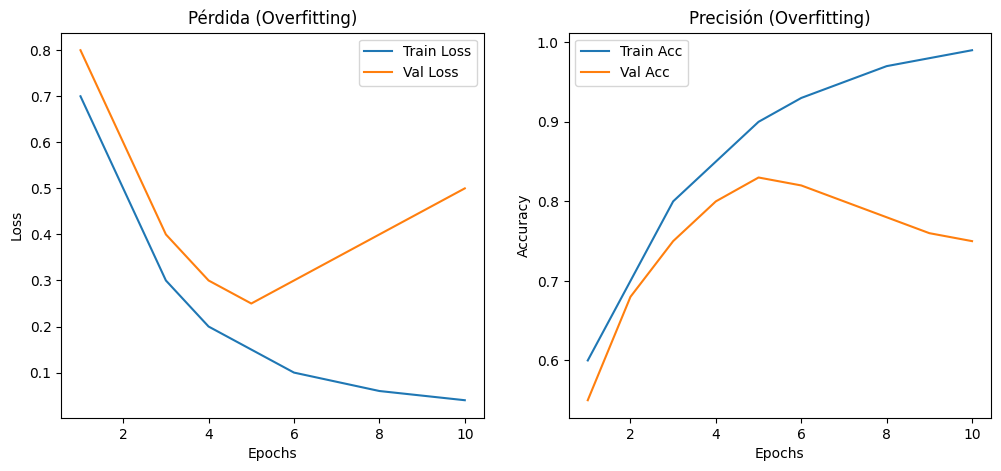

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

# Simulación (no son datos reales, es solo para mostrar el patrón típico)
train_loss = [0.7,0.5,0.3,0.2,0.15,0.1,0.08,0.06,0.05,0.04]
val_loss   = [0.8,0.6,0.4,0.3,0.25,0.3,0.35,0.4,0.45,0.5]

train_acc = [0.6,0.7,0.8,0.85,0.9,0.93,0.95,0.97,0.98,0.99]
val_acc   = [0.55,0.68,0.75,0.8,0.83,0.82,0.8,0.78,0.76,0.75]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Pérdida (Overfitting)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Precisión (Overfitting)")
plt.legend()

plt.show()


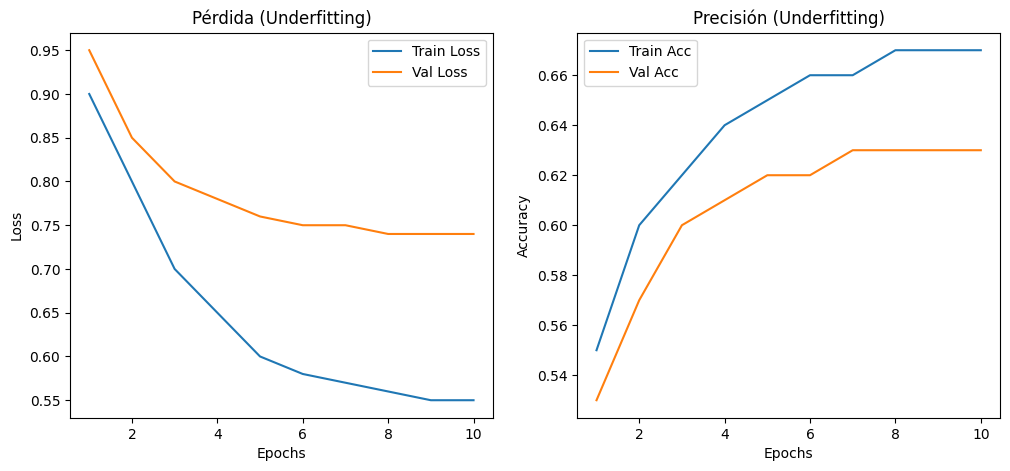

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)

# Simulación (ejemplo didáctico)
train_loss = [0.9,0.8,0.7,0.65,0.6,0.58,0.57,0.56,0.55,0.55]
val_loss   = [0.95,0.85,0.8,0.78,0.76,0.75,0.75,0.74,0.74,0.74]

train_acc = [0.55,0.6,0.62,0.64,0.65,0.66,0.66,0.67,0.67,0.67]
val_acc   = [0.53,0.57,0.6,0.61,0.62,0.62,0.63,0.63,0.63,0.63]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Pérdida (Underfitting)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Precisión (Underfitting)")
plt.legend()

plt.show()
